# 欢迎进入这个笔记本。

第一步（可选）：下载我的仓库到本地，里面有我写好的py文件。 如果你是直接下载这个notebook然后运行的，那么这一步是必需的。 如果你已经事先下载整个仓库然后打开了这个notebook，那么无需进行这一步操作。

In [3]:
!git clone https://github.com/lgy112112/Unet_Denoise_with_Tutorial.git
%cd Unet_Denoise_with_Tutorial

Cloning into 'Unet_Denoise_with_Tutorial'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 45 (delta 16), reused 16 (delta 0), pack-reused 0
Receiving objects: 100% (45/45), 20.90 KiB | 428.00 KiB/s, done.
Resolving deltas: 100% (16/16), done.
/content/Unet_Denoise_with_Tutorial


第二步：导入数据库
这个数据库来自剑桥大学APOLLO，是一个有332张影像的乳腺DR摄影数据库。
我们将下载到本地的Unet_Denoise_with_Tutorial文件夹里，然后解压，最后删除里面没用的pdf文件，只留下pgm图像文件。

In [4]:
!wget https://www.repository.cam.ac.uk/bitstreams/5960ab2b-5ea2-4db1-96ac-15b3605e7485/download
!unzip download
!rm -rf ./MIASDBv1.21/*.pdf

--2024-01-21 02:28:57--  https://www.repository.cam.ac.uk/bitstreams/5960ab2b-5ea2-4db1-96ac-15b3605e7485/download
Resolving www.repository.cam.ac.uk (www.repository.cam.ac.uk)... 131.111.98.102
Connecting to www.repository.cam.ac.uk (www.repository.cam.ac.uk)|131.111.98.102|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://api.repository.cam.ac.uk/server/api/core/bitstreams/5960ab2b-5ea2-4db1-96ac-15b3605e7485/content [following]
--2024-01-21 02:28:59--  https://api.repository.cam.ac.uk/server/api/core/bitstreams/5960ab2b-5ea2-4db1-96ac-15b3605e7485/content
Resolving api.repository.cam.ac.uk (api.repository.cam.ac.uk)... 131.111.98.101
Connecting to api.repository.cam.ac.uk (api.repository.cam.ac.uk)|131.111.98.101|:443... connected.
HTTP request sent, awaiting response... 200 200
Length: 1617327652 (1.5G) [application/zip]
Saving to: ‘download’

download            100%[===================>]   1.51G  13.5MB/s    in 2m 1s   

2024-01-21 02:31:02 (1

第三步：将下载来的文件转移到origin文件夹，我们后续会进行图像预处理

In [6]:
!mv ./MIASDBv1.21 ./origin

第四步：运行folder.py，这个py文件会创建noisy_images和clean_images文件夹，也会创建origin文件夹（当然它是已经存在的）

In [7]:
!python folder.py

文件夹 origin 已存在。
文件夹 noisy_images 已存在。
文件夹 clean_images 已存在。


第五步（可选）：定义椒盐噪声函数。这个函数会给图像加入自定义的椒盐噪声。
当然你也可以选下面的高斯噪声来加入（我更推荐高斯噪声），但记住两个噪声只能选其一加入。

In [8]:
def add_salt_and_pepper_noise(image, salt_pepper_ratio=0.5, amount=0.7):
    """
    向图像添加椒盐噪声
    :param image: 灰度图像数组
    :param salt_pepper_ratio: 椒盐比例，表示椒（黑点）和盐（白点）的比例
    :param amount: 噪声数量，表示图像中被噪声影响的像素比例
    :return: 添加噪声后的图像
    """
    # 复制图像
    noisy_image = np.copy(image)

    # 计算需要添加噪声的像素数量
    num_salt = np.ceil(amount * image.size * salt_pepper_ratio)
    num_pepper = np.ceil(amount * image.size * (1.0 - salt_pepper_ratio))

    # 随机选择添加盐（白点）的像素
    coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape]
    noisy_image[coords[0], coords[1]] = 255

    # 随机选择添加椒（黑点）的像素
    coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape]
    noisy_image[coords[0], coords[1]] = 0

    return noisy_image


import os
import numpy as np
from PIL import Image
import cv2
from tqdm import tqdm
from introduce import *

def resize_image(image, target_size=(256, 256)):
    """
    调整图像尺寸
    :param image: 输入图像
    :param target_size: 目标尺寸
    :return: 调整尺寸后的图像
    """
    return cv2.resize(image, target_size, interpolation=cv2.INTER_AREA)

def process_images(origin_dir, clean_dir, noisy_dir):
    if not os.path.exists(clean_dir):
        os.makedirs(clean_dir)
    if not os.path.exists(noisy_dir):
        os.makedirs(noisy_dir)

     # 使用 tqdm 包装循环
    for img_name in tqdm(os.listdir(origin_dir), desc="Processing Images"):
        img_path = os.path.join(origin_dir, img_name)
        if os.path.isfile(img_path):
            # 读取原始灰度图像
            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

            # 添加高斯噪声
            noisy_image = add_salt_and_pepper_noise(image)

            image = resize_image(image)
            noisy_image = resize_image(noisy_image)

            # 保存原始图像和带噪声的图像
            cv2.imwrite(os.path.join(clean_dir, img_name), image)
            cv2.imwrite(os.path.join(noisy_dir, img_name), noisy_image)

if __name__ == "__main__":
    origin = 'origin'  # 原始图像文件夹路径
    clean_images = 'clean_images'  # 无噪声图像文件夹路径
    noisy_images = 'noisy_images'  # 带噪声图像文件夹路径

    process_images(origin, clean_images, noisy_images)

Processing Images: 100%|██████████| 322/322 [02:18<00:00,  2.32it/s]


第六步（可选）：定义高斯噪声函数。这个函数会给图像加入自定义的高斯噪声。
当然你也可以选上面的椒盐噪声来加入（但我更推荐高斯噪声），但记住两个噪声只能选其一加入，也就是说如果你运行了上面的单元格，那你就不能运行这个。

In [ ]:

import os
import numpy as np
from PIL import Image
import cv2
from tqdm import tqdm

def add_gaussian_noise(image):
    """
    向图像添加高斯噪声
    :param image: 灰度图像数组
    :return: 添加噪声后的图像
    """
    row, col = image.shape
    mean = 0
    # var = 1.5
    sigma = 80
    gauss = np.random.normal(mean, sigma, (row, col))
    noisy_image = image + gauss
    noisy_image = np.clip(noisy_image, 0, 255)  # 裁剪到 0-255 范围
    return noisy_image.astype(np.uint8)  # 转换为 uint8 类型

def resize_image(image, target_size=(256, 256)):
    """
    调整图像尺寸
    :param image: 输入图像
    :param target_size: 目标尺寸
    :return: 调整尺寸后的图像
    """
    return cv2.resize(image, target_size, interpolation=cv2.INTER_AREA)

def process_images(origin_dir, clean_dir, noisy_dir):
    if not os.path.exists(clean_dir):
        os.makedirs(clean_dir)
    if not os.path.exists(noisy_dir):
        os.makedirs(noisy_dir)

     # 使用 tqdm 包装循环
    for img_name in tqdm(os.listdir(origin_dir), desc="Processing Images"):
        img_path = os.path.join(origin_dir, img_name)
        if os.path.isfile(img_path):
            # 读取原始灰度图像
            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

            # 添加高斯噪声
            noisy_image = add_gaussian_noise(image)

            image = resize_image(image)
            noisy_image = resize_image(noisy_image)

            # 保存原始图像和带噪声的图像
            cv2.imwrite(os.path.join(clean_dir, img_name), image)
            cv2.imwrite(os.path.join(noisy_dir, img_name), noisy_image)

if __name__ == "__main__":
    origin = 'origin'  # 原始图像文件夹路径
    clean_images = 'clean_images'  # 无噪声图像文件夹路径
    noisy_images = 'noisy_images'  # 带噪声图像文件夹路径

    process_images(origin, clean_images, noisy_images)


Processing Images: 100%|██████████| 322/322 [02:37<00:00,  2.05it/s]


第七步：验证噪声图片是否存在

选中的图像: mdb114rs.pgm
噪声水平 (MSE): 113.14762878417969


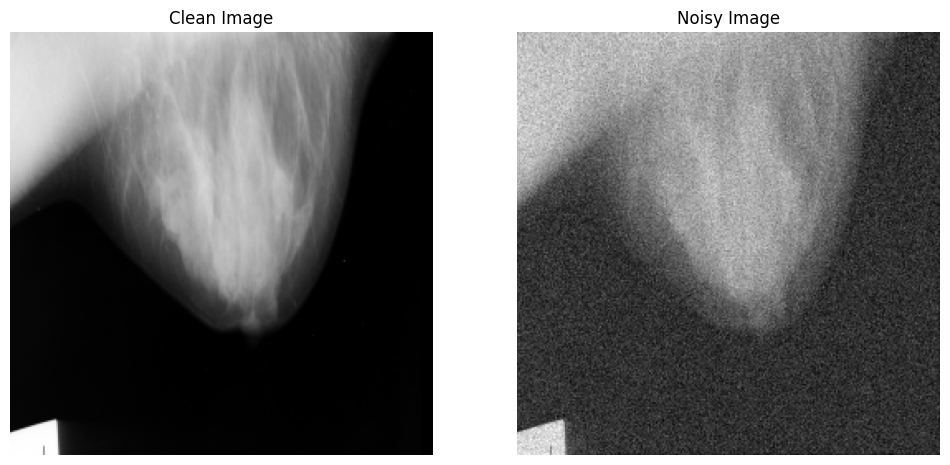

In [9]:
import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt

def calculate_mse(image1, image2):
    """
    计算两个图像之间的均方误差 (MSE)
    :param image1: 第一个图像
    :param image2: 第二个图像
    :return: 两个图像之间的 MSE
    """
    return np.mean((image1 - image2) ** 2)

def measure_noise_level(folder1, folder2):
    """
    随机选择一个 pgm 图像，比较两个文件夹中相同图像的噪声水平
    :param folder1: 第一个文件夹路径（clean_images）
    :param folder2: 第二个文件夹路径（noisy_images）
    :return: 噪声水平 (MSE)
    """
    pgm_files = [f for f in os.listdir(folder1) if f.endswith('.pgm')]
    if not pgm_files:
        raise ValueError("没有找到 pgm 文件")

    image_name = random.choice(pgm_files)
    print(f"选中的图像: {image_name}")

    path1 = os.path.join(folder1, image_name)
    path2 = os.path.join(folder2, image_name)

    if not os.path.exists(path1) or not os.path.exists(path2):
        raise ValueError("图像文件不存在于提供的文件夹路径中")

    image1 = cv2.imread(path1, cv2.IMREAD_GRAYSCALE)
    image2 = cv2.imread(path2, cv2.IMREAD_GRAYSCALE)

    if image1.shape != image2.shape:
        raise ValueError("两个图像的尺寸不相同")

    mse = calculate_mse(image1, image2)
    return mse, image1, image2

# 示例使用
folder1 = 'clean_images'
folder2 = 'noisy_images'
noise_level, image1, image2 = measure_noise_level(folder1, folder2)
print(f"噪声水平 (MSE): {noise_level}")
# 展示两张图片
%matplotlib inline
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(image1, cmap='gray')
plt.title('Clean Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image2, cmap='gray')
plt.title('Noisy Image')
plt.axis('off')

plt.show()

第八步：初始化VGG。我为了加强U-Net捕捉特征信息加入了VGG16

In [10]:
!python VGG_init.py

第九步：开始训练吧！如果你想设置训练参数，比如训练轮次num_epochs、批处理大小batch_size，你可以点开左边的train.py来修改

In [11]:
!python train.py

Traceback (most recent call last):
  File "/content/Unet_Denoise_with_Tutorial/train.py", line 25, in <module>
    perceptual_loss = PerceptualLoss().to(device)
NameError: name 'PerceptualLoss' is not defined


第十步：用得到的pth模型文件进行预测

In [ ]:
!python predict.py